In [1]:
%load_ext autoreload
%autoreload 2

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xarray as xr
import os
import copy

In [3]:
import scipy.signal
import torch
from torch import nn
from torch.utils.data import DataLoader

In [4]:
from Game import Game
from Player import Player
from Event import Event
from Moment import Moment
from Ball import Ball

In [10]:
for file in tqdm(os.listdir('data')):
    if file.endswith('.json'):
        game = Game('data/'+file)
        game.read_meta_data()

  0%|          | 0/1268 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
position_ids = torch.arange(1024)[:, None]
d = 512
a = (position_ids/(10000*2*np.pi/2/np.pi)**(torch.arange(d)/d)).sin()

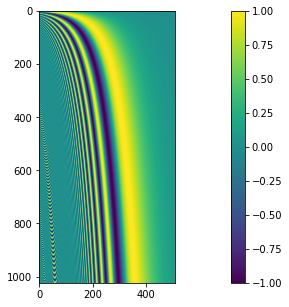

In [12]:
plt.figure(figsize=(20, 5))
plt.imshow(a.numpy()); plt.colorbar()

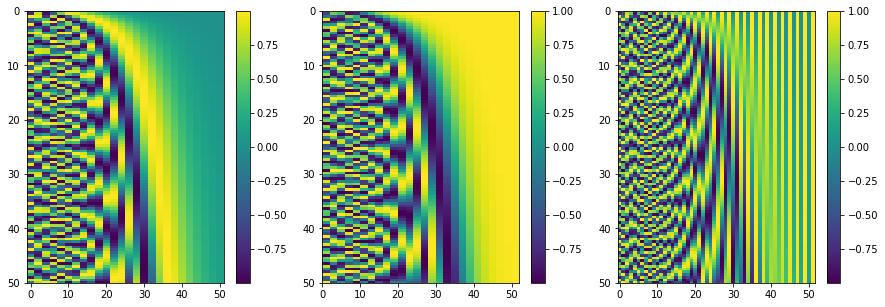

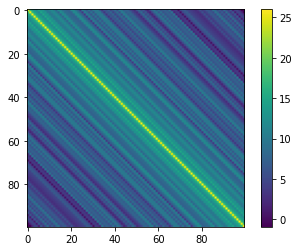

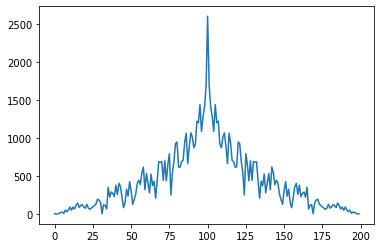

In [13]:
    
import util
a = util.fourier_pos(0, 50, t=torch.linspace(0, 50, 100), d=52, do_viz=True)
plt.imshow(a@a.T); plt.colorbar()
plt.show()
plt.plot([(a@a.T).diagonal(i).sum().item() for i in range(-100, 100)])
plt.show()

In [28]:
path = 'data/'+[file for file in os.listdir('data') if file.endswith('.json')][0]
print(path)
game = Game(path)
game.read_json(tqdm=tqdm)

data/0021500120.json
loading  483


  0%|          | 0/483 [00:00<?, ?it/s]

In [29]:
game.team2onehot = {0: 0, game.home_team.id: 1, game.guest_team.id: 2}
print(len(game.team2onehot), game.team2onehot)
game.pid2onehot = {0: 0}
game.pid2onehot.update({a: idx+1 for idx, a in enumerate(game.player_ids_dict.keys())})
print(len(game.pid2onehot), game.pid2onehot)

3 {0: 0, 1610612763: 1, 1610612744: 2}
27 {0: 0, 203210: 1, 203893: 2, 201584: 3, 2754: 4, 201144: 5, 1713: 6, 2440: 7, 201145: 8, 201188: 9, 2216: 10, 1626185: 11, 201148: 12, 203919: 13, 201574: 14, 201578: 15, 2738: 16, 202691: 17, 101106: 18, 2571: 19, 203949: 20, 203546: 21, 203110: 22, 201939: 23, 203105: 24, 2733: 25, 203084: 26}


In [307]:
import preprocess
dg_raw = preprocess.load_data_game(game, tqdm=tqdm)
dg = preprocess.preprocess(dg_raw)
# dg_raw_ = preprocess.load_data_game(game, tqdm=tqdm)
# dg_ = preprocess.preprocess(dg_raw_)

# list(zip([e.shape for e in dg_raw], [e[:, 2].sum() for e in dg_raw]))

  0%|          | 0/483 [00:00<?, ?it/s]

In [47]:
from collections import defaultdict

In [77]:
moment.players[0]

201145

In [247]:
def load_data_game(game, tqdm=None):
    data = defaultdict(lambda : [])
    for i_event, event in enumerate(game.events if tqdm is None else tqdm(game.events)):
        if len(event.moments)==0:
            continue
            
        ids_player = torch.full((len(event.moments), 11), fill_value=-1, dtype=int)
        ids_team = torch.full((len(event.moments), 11), fill_value=-1, dtype=int)
        pos = torch.full((len(event.moments), 11, 3), fill_value=torch.nan, dtype=float)
        time = torch.full((len(event.moments), 3), fill_value=torch.nan, dtype=float)
        
        for i_moment, moment in enumerate(event.moments):
            quarter_clock = moment.game_clock
            # game_clock = quarter_clock+(4-moment.quarter)*12*60
            # game_clock = int((game_clock+.005)*100)/100.
            
            a = [torch.nan if i is None else i for i in [moment.game_clock, moment.shot_clock, moment.quarter]]
            time[i_moment, :] = torch.tensor(a)
            if len(moment.players)>0:
                pos[i_moment, 0, :] = torch.tensor([moment.ball.x, moment.ball.y, moment.ball.radius])
                pos[i_moment, 1:1+len(moment.players), :] = torch.tensor([[player.x, player.y, 0] for player in moment.players], dtype=float)
                ids_player[i_moment, 1:1+len(moment.players)] = torch.tensor([player.id for player in moment.players], dtype=float)
                ids_team[i_moment, 1:1+len(moment.players)] = torch.tensor([player.team.id for player in moment.players], dtype=float)
        # only add if this new event is different from the previous one
        if len(data['pos'])==0 or not np.array_equal(pos.numpy(), data['pos'][-1].numpy(), equal_nan=True):
            data['pos'].append(pos)
            data['ids_player'].append(ids_player)
            data['ids_team'].append(ids_team)
            data['time'].append(time)
            
    return data

def preprocess(data):
    data = copy.copy(data)
    for key in data:
        print(key)
        data[key] = torch.cat(data[key], dim=0)
    
    # only include the first instance of a time stamp (to two decimals)
    # t_binned = ((t+0.001)*100).astype(int)
    # print(len(t_binned))
    # _, idxs = np.unique(t_binned, return_index=True)
    # print(len(idxs))
    # data_game = data_game[:, idxs]
    
    # sort the times in case they're out of order
    # idxs = np.argsort(data_game[0])[::-1]
    # plt.plot(idxs)
    # print((idxs[1:]-idxs[:-1]))
    # print((idxs[1:]-idxs[:-1] == -1).all())
    # data_game = data_game[:, idxs] #don't sort??
    return data
dg_raw = load_data_game(game, tqdm=tqdm)
dg = preprocess(dg_raw)

  0%|          | 0/483 [00:00<?, ?it/s]

pos
ids_player
ids_team
time


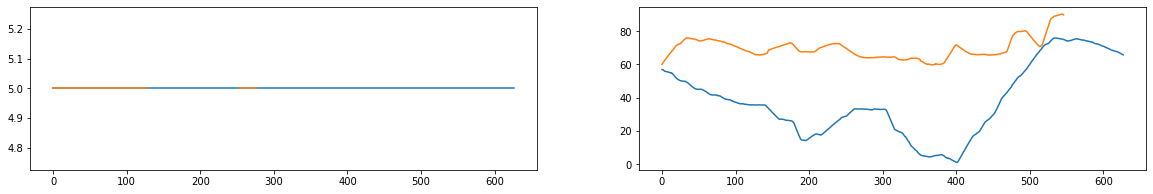

In [284]:
i = 6
plt.figure(figsize=(20, 3))
plt.subplot(121)
plt.plot(dg_raw['time'][i][:, 1])
plt.plot(dg_raw['time'][i+1][:, 1])
plt.subplot(122)
plt.plot(dg_raw['pos'][i][:, 0, 0])
plt.plot(dg_raw['pos'][i+1][:, 0, 0])

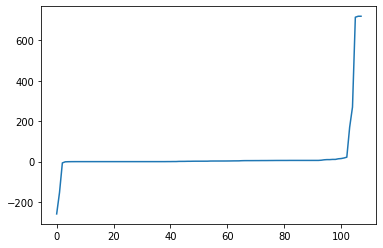

In [306]:
a = dg['time'][:, 0].diff()
a = np.unique(a.numpy())
# a = np.modf(a)[0]
plt.plot(a)


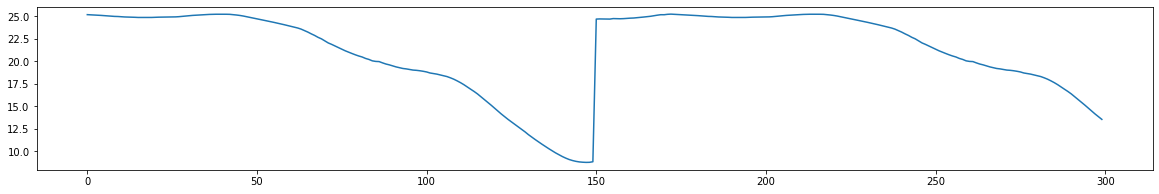

In [253]:
plt.figure(figsize=(20,3))
# plt.plot(dg['time'][:, 0][:300].numpy())
plt.plot(dg['pos'][:, 1, 1][:300].numpy())

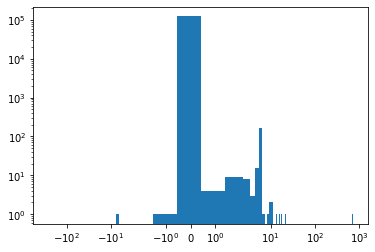

In [239]:
a = dg['time'][:, 0].diff()
plt.hist(a.numpy(), bins=1000);
plt.xscale('symlog')
plt.yscale('log')

In [240]:
a.min(), a.max()

(tensor(-259., dtype=torch.float64), tensor(720., dtype=torch.float64))

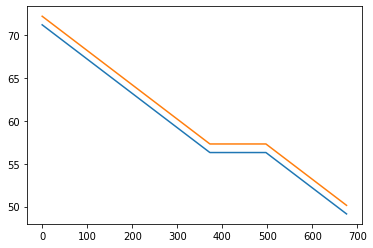

In [191]:
i = 57
# plt.plot(dg_raw['time'][i][:, 1])
# plt.plot(dg_raw_[i][:, 2])
plt.plot(dg_raw['time'][i][:, 0])
plt.plot(dg_raw_[i][:, 1]+1)

In [12]:
a = []
for i in range(len(dg_raw)):
    t = dg_raw[i][:, 0]
    dt = np.diff(t)
    a.append(dt)
    # print(dt.min(), dt.max())


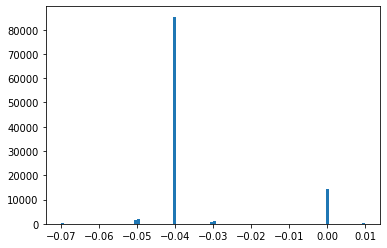

In [13]:
plt.hist(np.concatenate(a).clip(-.07, .01), bins=100);
# plt.yscale('log')

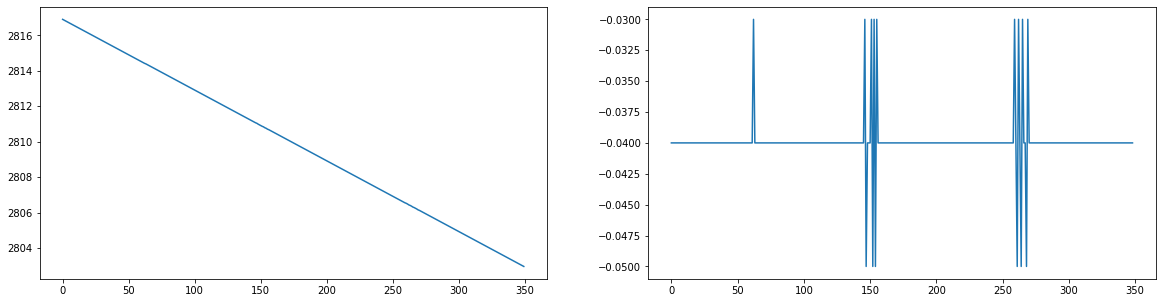

In [280]:
t = dg_raw[3][:, 0]
dt = np.diff(t)
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(t)
plt.subplot(122)
# plt.hist(dt, bins=100);
plt.plot(dt)

In [277]:
dt.argmax()

72

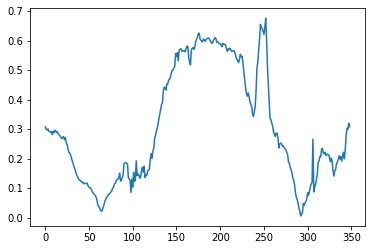

In [281]:
x = dg_raw[3][:, [10,11]]
v = x[1:]-x[:-1]
plt.plot(torch.from_numpy(v).norm(dim=-1).numpy())
# plt.gca().axvline(dt.argmax(),c='r')

In [13]:
np.isnan(dg).any(axis=0)

array([False, False,  True, False, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

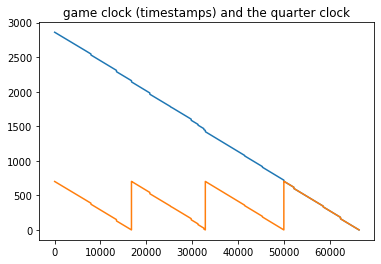

0.03 2861.14
-20.700000000000017 -0.043081220261398545 -0.009999999999763531


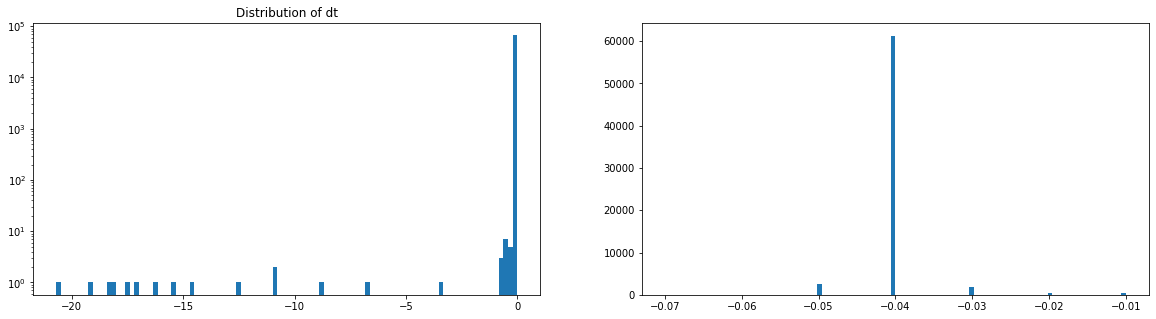

In [14]:
plt.plot(dg[:, 0])
plt.plot(dg[:, 1])
plt.title('game clock (timestamps) and the quarter clock')
plt.show()

t = dg[:, 0]
print(t.min(), t.max())
dt = np.diff(t)
assert (dt<0).all(), 'timestamps not all decreasing'
print(dt.min(), dt.mean(), dt.max())

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(dt, bins=100);
plt.title('Distribution of dt')
plt.yscale('log')
plt.subplot(122)
plt.hist(dt[dt>-.1], bins=100);
# plt.yscale('log')
plt.show()

(-0.05, 0.0)

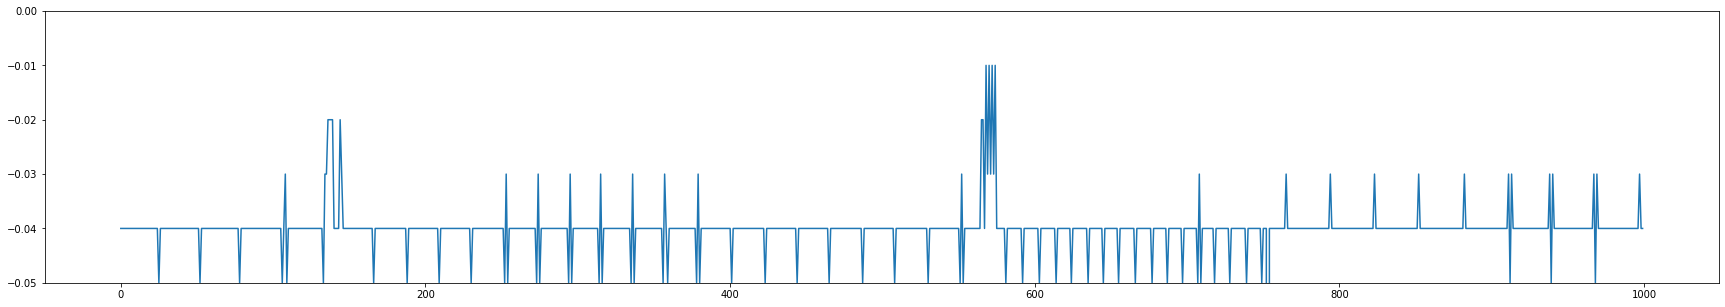

In [15]:
plt.figure(figsize=(30, 5))
plt.plot(dt[20000:21000])
plt.ylim(-.05, 0)

In [16]:
print(f"dt decreasing for {(dt<0.).sum()} frames and increasing for {(dt>=0.).sum()} frames")

dt decreasing for 66412 frames and increasing for 0 frames


(-3.4655285, 101.6141385, 6.304955500000001, 49.7933345)

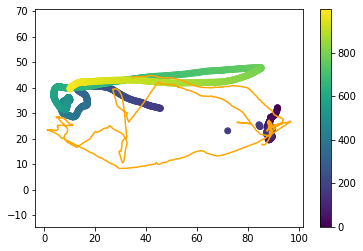

In [80]:
x = dg[:1000, 10]
y = dg[:1000, 11]
plt.scatter(x, y, c=np.arange(len(x)))
plt.colorbar()
x = dg[:1000, 5]
y = dg[:1000, 6]
plt.plot(x,y, color='orange')

plt.axis('equal')
# plt.ylim(0, 50)
# plt.xlim(0, 94)

In [308]:
import torch
from torch import nn

In [309]:
from collections import defaultdict

In [310]:
from constants import max_speed_ball, max_speed_human

In [311]:
from dataset import BasketballDataset

In [312]:
ds = BasketballDataset(game, dg, input_shot_clock=True, input_p_id=False, tqdm=tqdm)
# x_mean = ds.x.mean(axis=(0, 1))
# x_std = ds.x.std(axis=(0, 1))
# y_mean = ds.y.mean(axis=(0, 1))
# y_std = ds.y.std(axis=(0, 1))
# print([i.shape for i in ds[0]])
# print(len(ds))

Creating dataset
dg_m: torch.Size([71651, 4, 48]) | 

Removing 16049 frames for NaN values
Removing 130 items for bad dt
Removing 221 frames for high ball speed
Removing 157 frames for high player speed
dg_m: torch.Size([55094, 4, 48]) | t_m: torch.Size([55094, 4]) | dt_m: torch.Size([55094, 3]) | dt: torch.Size([55094]) | t_shot: torch.Size([55094]) | id_p: torch.Size([55094, 11]) | id_team: torch.Size([55094, 11]) | x_m: torch.Size([55094, 4, 11, 3]) | v_m: torch.Size([55094, 3, 11, 3]) | a_m: torch.Size([55094, 2, 11, 3]) | x: torch.Size([55094, 11, 3]) | nx: torch.Size([55094, 11, 3]) | v: torch.Size([55094, 11, 3]) | nv: torch.Size([55094, 11, 3]) | a: torch.Size([55094, 11, 3]) | na: torch.Size([55094, 11, 3]) | 



In [313]:
ds.ds.keys()

dict_keys(['dg_m', 't_m', 'dt_m', 'dt', 't_shot', 'id_p', 'id_team', 'x_m', 'v_m', 'a_m', 'x', 'nx', 'v', 'nv', 'a', 'na'])

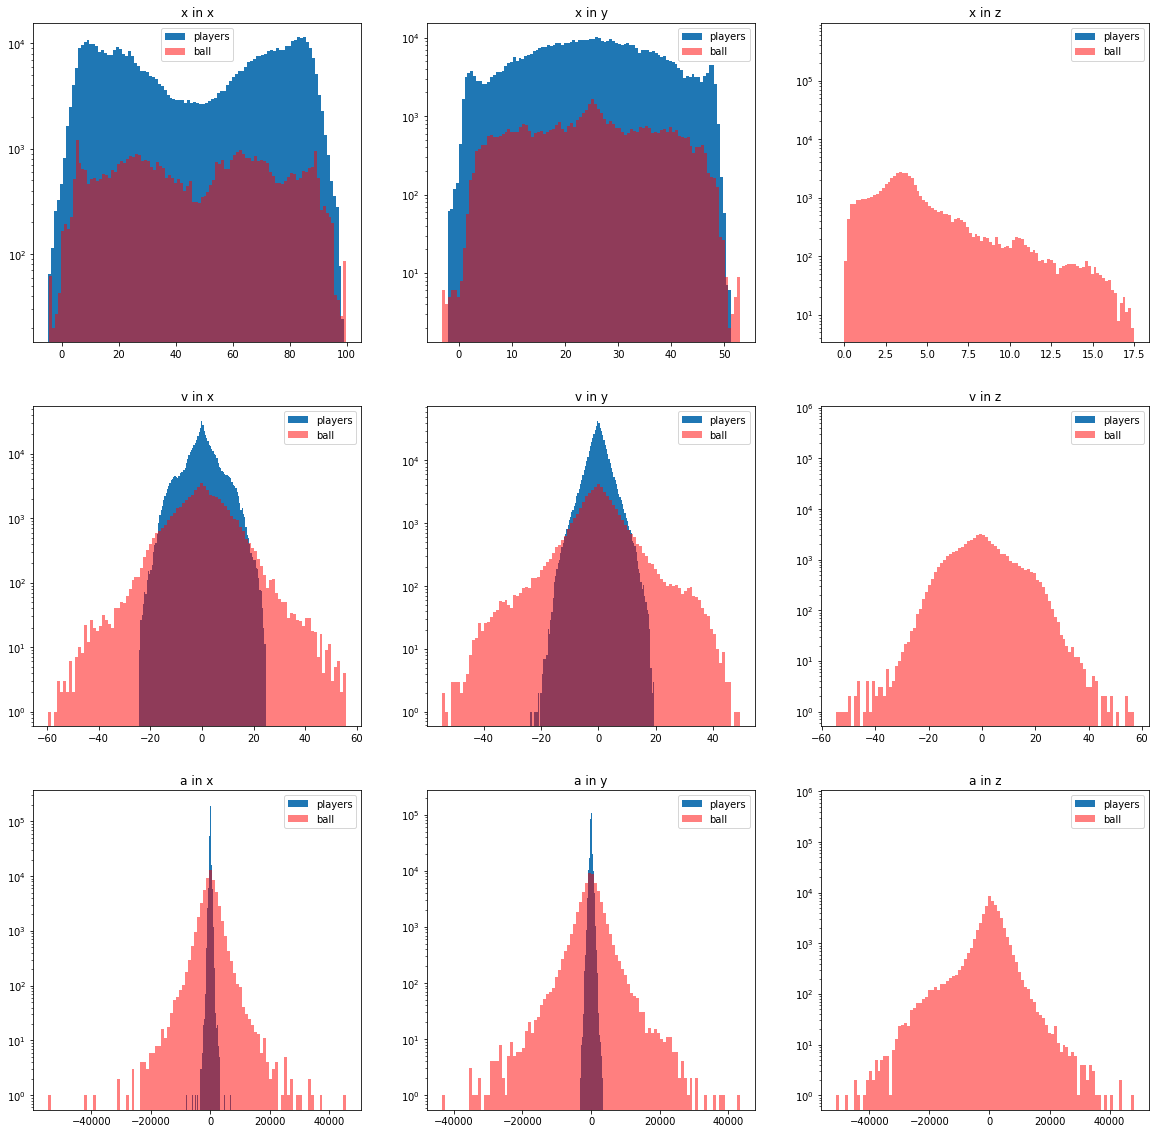

In [314]:
plt.figure(figsize=(20, 20))
for i, key in enumerate(['x', 'v', 'a']):
    for j, direction in enumerate(['x', 'y', 'z']):
        plt.subplot(3, 3, i*3+j+1)
        plt.title(f'{key} in {direction}')
        plt.hist(ds.ds[f'{key}'][..., 1:, j].flatten().numpy(), bins=100, label='players');
        plt.hist(ds.ds[f'{key}'][..., :1, j].flatten().numpy(), bins=100, color=[1,0,0,.5], label='ball');
        plt.yscale('log')
        plt.legend()
    
# plt.subplot(1, 4, 4)
# plt.hist(ds.ds['v'][..., 1:, :].norm(dim=-1).flatten().numpy(), bins=100);
# plt.hist(ds.ds['v'][..., :1, :].norm(dim=-1).flatten().numpy(), bins=100, color=[1,0,0,.5]);
# plt.yscale('log')
plt.show()

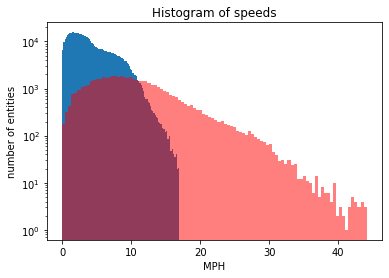

In [315]:
speed = (ds.ds['v'].norm(dim=-1))
plt.title('Histogram of speeds')
plt.xlabel('MPH'); plt.ylabel('number of entities')
plt.hist(speed[:, 1:].flatten().numpy()/1.467, bins=100, label='Players');
plt.hist(speed[:, 0].flatten().numpy()/1.467, bins=100, color=[1,0,0,.5], label='Ball');
plt.yscale('log')

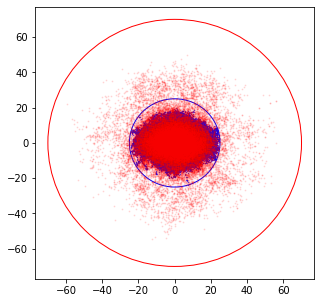

In [316]:
v = ds.ds['v']

plt.figure(figsize=(5,5))
plt.scatter(v[:, 1:, 0].flatten().numpy(), v[:, 1:, 1].flatten().numpy(), s=.1, color=[0., 0., 1., 1.])
plt.gca().add_patch(plt.Circle((0, 0), max_speed_human, color='b', fill=False))

plt.scatter(v[:, 0, 0].flatten().numpy(), v[:, 0, 1].flatten().numpy(), s=1, color=[1., 0, 0, .1])
plt.gca().add_patch(plt.Circle((0, 0), max_speed_ball, color='r', fill=False))

plt.show()


In [64]:
from discrete_prob import DiscretizeContinuousSpace
n_bins = np.ones(2, dtype=int)*2
dcs = DiscretizeContinuousSpace(np.zeros(2)-1.5, np.zeros(2)+1.5, n_bins)


[-1.5 -1.5] [1.5 1.5] [2 2]


In [494]:
v = ds.ds['nv']

In [495]:
# v.min(dim=-2).values.min(dim=-2).values, v.max(dim=-2).values.max(dim=-2).values
v.mean(dim=(-2, -3)), v.std(dim=(-2, -3))*3, 

(tensor([-0.0462, -0.0166, -0.0024], dtype=torch.float64),
 tensor([22.3087, 13.4190,  8.4228], dtype=torch.float64))

In [496]:
dcs.vec2bin(v[..., :2].numpy())

array([[1, 3, 3, ..., 1, 1, 2],
       [1, 3, 3, ..., 1, 3, 2],
       [0, 3, 3, ..., 1, 3, 2],
       ...,
       [3, 1, 2, ..., 3, 3, 0],
       [1, 1, 2, ..., 3, 3, 0],
       [2, 1, 2, ..., 3, 3, 0]])

  0%|          | 0/1000 [00:00<?, ?it/s]

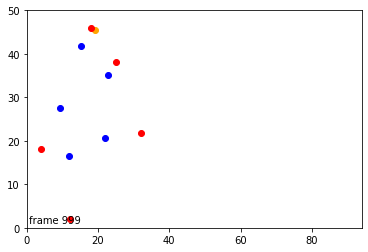

In [667]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure()
camera = Camera(fig)
for frame_idx in tqdm(range(1000)):
    plt.text(0.5, 1.01, f'frame {frame_idx}')#, transform=ax.transAxes)
    plt.scatter(*ds.ds['x'][frame_idx, :1][:, :2].numpy().T, c='orange')
    plt.scatter(*ds.ds['x'][frame_idx, 1:6][:, :2].numpy().T, c='b')
    plt.scatter(*ds.ds['x'][frame_idx, 6:][:, :2].numpy().T, c='r')
    plt.xlim(0, 94)
    plt.ylim(0, 50)
    camera.snap()

animation = camera.animate(interval=40)
# plt.close(fig)
# HTML(animation.to_html5_video())
animation.save('animation.mp4')

# things to track for this experiment:
- ball x, ball y
- p1 x, p1 y, p1 vx, p1 vy, p1 ax, p1 ay
- ...


# outputs
- movements


In [319]:
from net import ModelNet

In [320]:
    
net = ModelNet(game)
# net(x_batch).shape

In [67]:
from discrete_prob import DiscretizeContinuousSpace
n_bins = np.ones(2, dtype=int)*2
dcs = DiscretizeContinuousSpace(np.zeros(2)-1.5, np.zeros(2)+1.5, n_bins)

[-1.5 -1.5] [1.5 1.5] [2 2]


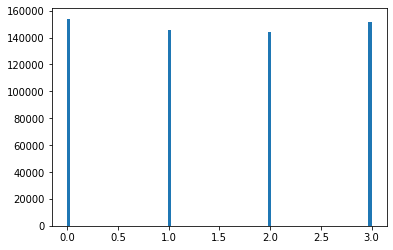

In [68]:
a = ds.ds['x']
x_mean, x_std = a.mean(dim=(-2, -3)), a.std(dim=(-2, -3))
batch_y = torch.from_numpy(dcs.vec2bin(ds.ds['nv'][..., :2].numpy()))
plt.hist(batch_y.flatten().numpy(), bins=100);

In [69]:
ds.ds['x'].shape

torch.Size([54136, 11, 3])

In [70]:
ds.ds['x'].numel()*4*10/1e9

0.07145952

In [321]:
from dataset import index_data_dict

In [323]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [332]:
net = ModelNet(game, n_inputs=60, n_outputs=3, embed_dim=60, n_heads=5, mlp_dim=120).to(device)
loss_fn = nn.CrossEntropyLoss()

print(np.sum([p.numel() for p in net.parameters()]))
for p in net.parameters():
    p.data.uniform_(-1e-3, 1e-3)

opt = torch.optim.Adam(net.parameters(), lr=1e-2)

losses = []
for idx_epoch in tqdm(range(50)):
    pbar = tqdm(torch.randperm(len(ds.ds['x'])).split(1024), leave=False)
    for batch_idx in pbar:
        batch = index_data_dict(ds.ds, batch_idx)
        x = batch['x'].float().to(device)
        # x_normalized = ((x-x_mean)/x_std).float()
        id_team = batch['id_team'].to(device)
        id_player = batch['id_p'].to(device)
        
        # inputs = torch.cat([x_normalized, nn.functional.one_hot(batch['id_team'].long()).float()], dim=-1)
        
        # y = torch.from_numpy(dcs.vec2bin(batch['nv'][..., :2].numpy()))
        y = batch['nv'].to(device)
        
        y_batch_pred = net.forward(x, id_team=id_team, id_player=id_player)
        
        # print(batch_y.shape, y_batch_pred.shape)
        # loss = loss_fn(y_batch_pred.reshape(-1, 4), y.flatten())
        loss = (y_batch_pred-y).pow(2.).mean()
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        pbar.set_postfix({'loss': loss.item()})


152943


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

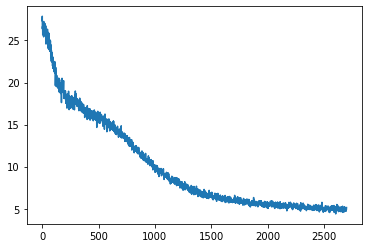

In [333]:
plt.plot(losses)

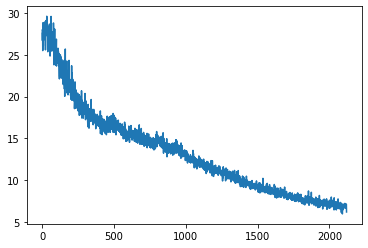

In [79]:
plt.plot(losses) #for the mse loss with fourier x, embedded id_team, embedded id_player

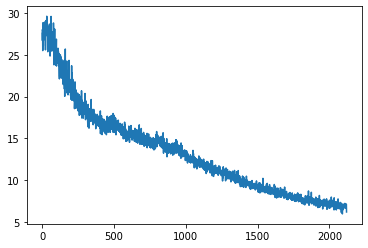

In [79]:
plt.plot(losses) #for the mse loss with fourier x, embedded id_team, embedded id_player

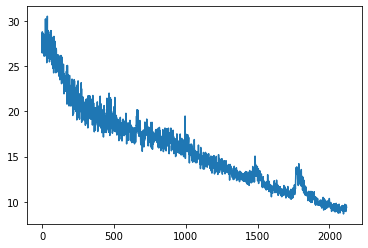

In [53]:
plt.plot(losses) #for the mse loss with fourier x, embedded id_team

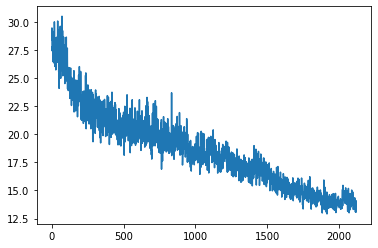

In [616]:
plt.plot(losses) #for the mse loss with xyz inputs

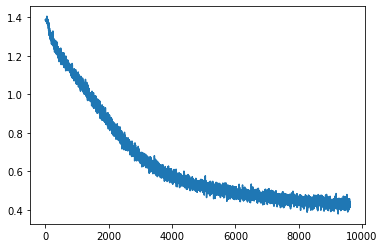

In [612]:
plt.plot(losses) #for the crossentropy 4-quadrant classification loss with xyz inputs

In [535]:
v = ds.ds['v']
nv = ds.ds['nv']
a = dcs.vec2bin(v[..., :2].numpy())
b = dcs.vec2bin(nv[..., :2].numpy())

In [118]:
batch = index_data_dict(ds.ds, 0)
x = batch['x'][None].float()
id_team = batch['id_team'][None]
id_player = batch['id_p'][None]
xs = []

for i in tqdm(range(100)):
    xs.append(x.detach().cpu().clone())
    nv = net.forward(x, id_team, id_player)
    x = x+nv*0.04

xs = torch.stack(xs)[:, 0]

  0%|          | 0/100 [00:00<?, ?it/s]

In [121]:
x.shape

torch.Size([11, 3])

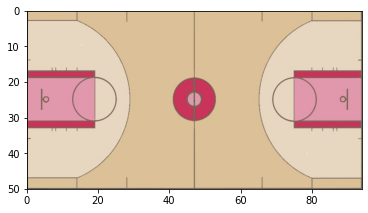

In [181]:
from Constant import Constant

court = plt.imread("court.png")
plt.imshow(court, zorder=0, extent=[Constant.X_MIN, Constant.X_MAX - Constant.DIFF,
                                    Constant.Y_MAX, Constant.Y_MIN])

In [182]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure()
camera = Camera(fig)
for i in tqdm(range(0, 100, 1)):
    x = xs[i]
    plt.text(0.5, 1.01, f'frame {i}')#, transform=ax.transAxes)
    plt.scatter(*x[:1, :2].numpy().T, c='orange')
    plt.scatter(*x[1:6, :2].numpy().T, c='b')
    plt.scatter(*x[6:, :2].numpy().T, c='r')
    plt.xlim(0, 94)
    plt.ylim(0, 50)
    
    plt.imshow(court, zorder=0, extent=[Constant.X_MIN, Constant.X_MAX - Constant.DIFF,
                                        Constant.Y_MAX, Constant.Y_MIN])
    camera.snap()

animation = camera.animate(interval=40)
plt.close(fig)
HTML(animation.to_html5_video())
# animation.save('animation.mp4')

  0%|          | 0/100 [00:00<?, ?it/s]

In [169]:
success = []
for experiment in tqdm(range(1000)):
    np.random.seed(experiment)
    box_slips = np.random.permutation(100)
    found = np.zeros((100,), dtype=bool)
    for i in range(100):
        current_box = i
        for t in range(50):
            if box_slips[current_box]==i:
                found[i] = True
                break
            current_box = box_slips[current_box]

    # print(f'success: {found.all()}, # of people found their number: {found.sum()}, # of people not found their number {100-found.sum()}')
    success.append(found.all())

print(np.array(success).sum()/len(success))


  0%|          | 0/1000 [00:00<?, ?it/s]

0.31
